# Personalized Recommendation System 

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore")
warnings.resetwarnings()

/kaggle/input/kindle-reviews/kindle_reviews.csv
/kaggle/input/kindle-reviews/kindle_reviews.json


In [2]:
df = pd.read_csv('/kaggle/input/kindle-reviews/kindle_reviews.csv')
df.head(5)

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


# EDA

In [3]:
df.describe()

,Unnamed: 0,overall,unixReviewTime
count,982619.000000,982619.000000,9.826190e+05
mean,491309.000000,4.347801,1.378183e+09
std,283657.816418,0.955056,2.298476e+07
min,0.000000,1.000000,9.522144e+08
25%,245654.500000,4.000000,1.365206e+09
50%,491309.000000,5.000000,1.383523e+09
75%,736963.500000,5.000000,1.396051e+09
max,982618.000000,5.000000,1.406074e+09


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982619 entries, 0 to 982618
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      982619 non-null  int64 
 1   asin            982619 non-null  object
 2   helpful         982619 non-null  object
 3   overall         982619 non-null  int64 
 4   reviewText      982597 non-null  object
 5   reviewTime      982619 non-null  object
 6   reviewerID      982619 non-null  object
 7   reviewerName    978803 non-null  object
 8   summary         982618 non-null  object
 9   unixReviewTime  982619 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 75.0+ MB


# Missing Values

In [5]:
df.isnull().sum().sort_values(ascending = False)


reviewerName      3816
reviewText          22
summary              1
Unnamed: 0           0
asin                 0
helpful              0
overall              0
reviewTime           0
reviewerID           0
unixReviewTime       0
dtype: int64

In [6]:
# Missing values in percentage
missing_percentage = df.isnull().sum().sort_values(ascending = False) /len(df) * 100
missing_percentage

reviewerName      0.388350
reviewText        0.002239
summary           0.000102
Unnamed: 0        0.000000
asin              0.000000
helpful           0.000000
overall           0.000000
reviewTime        0.000000
reviewerID        0.000000
unixReviewTime    0.000000
dtype: float64

In [7]:
# percentage of missing values in our dataset
total_missing_percentage = (((df.isnull().sum()).sum())/df.size)*100
total_missing_percentage

0.03906905932004164

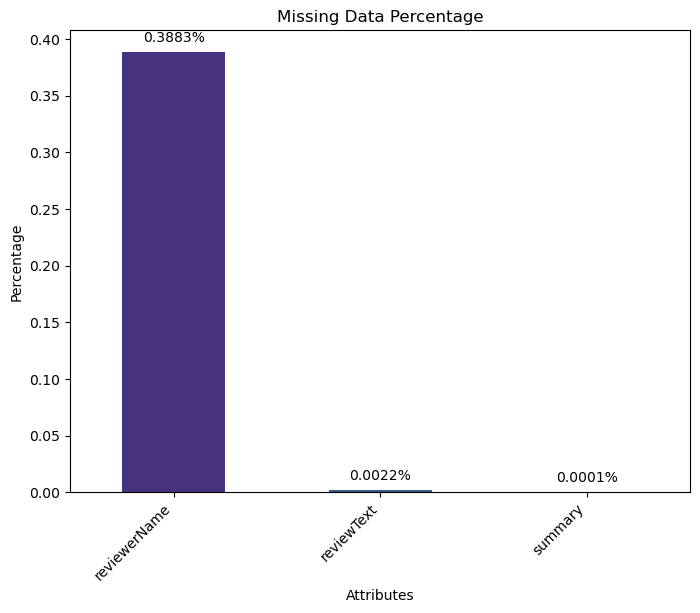

In [8]:
# missing_percentage[missing_percentage!=0].plot(kind  = 'barh')

plt.figure(figsize=(8, 6))

# Plot the missing percentages with attributes on the x-axis
ax = missing_percentage[missing_percentage != 0].plot(kind='bar', color=sns.color_palette("viridis"))

plt.title('Missing Data Percentage')
plt.xlabel('Attributes')
plt.ylabel('Percentage')

# Annotate the bars with percentage values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
plt.xticks(rotation=45, ha='right')
plt.show()

**As the percentage of missing data is minimal, there is no significant need of data cleaning.**

# Correlation between review-sentiments and ratings 

In [13]:
# import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Drop rows with missing reviewText values
temp_df = df.dropna(subset=['reviewText'])

# Define a function to calculate sentiment scores
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Calculate sentiment scores using the optimized apply method
temp_df['sentiment_score'] = temp_df['reviewText'].apply(get_sentiment_score)

# Calculate the correlation matrix
correlation_matrix = temp_df[['sentiment_score', 'overall']].corr()

# Display the correlation matrix
print(correlation_matrix)

                 sentiment_score   overall
sentiment_score         1.000000  0.309902
overall                 0.309902  1.000000


**Through testing the dataset containing both rating scores and sentiment scores of review text, we have discovered a strong correlation, confirming the authenticity and reliability of the review ratings.**

# Distribution of Rating before Decay

Text(0, 0.5, 'Count')

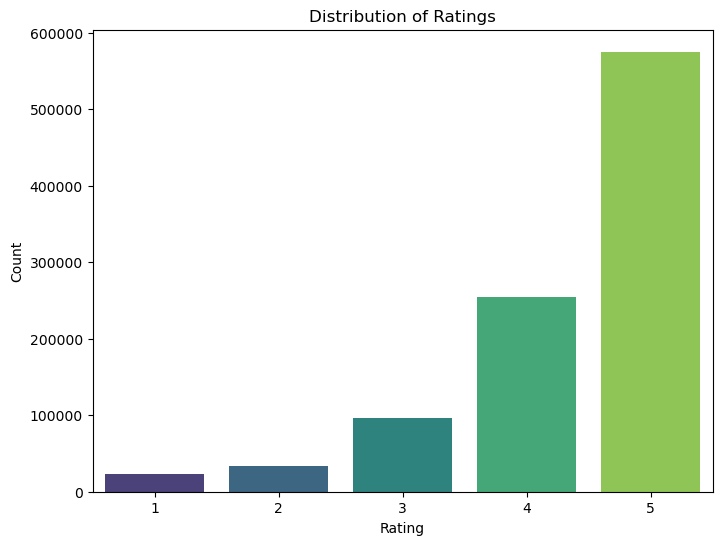

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='overall', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Distribution of Rating after Decay

In [15]:
max_value = df['unixReviewTime'].max()
df['absolute_time'] = (max_value- df['unixReviewTime'])/(86400)
df['decay_factor'] = np.exp(-df['absolute_time'] / 864)
df['old_rating']=df['overall']
df['overall']=df['overall']*df['decay_factor']

Text(0, 0.5, 'Count')

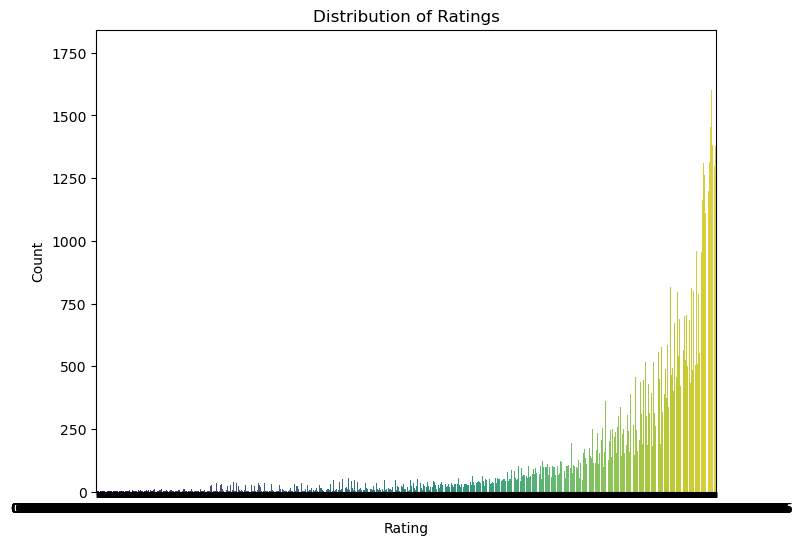

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='overall', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

**After apply decay factor** the ratings are now weighted with respect to time and score which in turn has made the values Continuous.

# Recommendation System Techniques

## Aging Technique

The aging technique preserves actual ratings while considering time factors. It involves:

- Assigning more weight to recent reviews.
- Applying a decay factor based on review recency.
- Calculating a new overall rating that balances time and rating.

## Matrix Factorization

Matrix factorization addresses challenges in recommendation systems:

### Latent Factors & Patterns

Matrix factorization, especially using Singular Value Decomposition (SVD), uncovers:

- Hidden factors influencing user preferences and item features.
- Identification of complex patterns, enhancing recommendation accuracy.

### Efficient Dimension Reduction

Matrix factorization, specifically SVD, achieves:

- Efficiently reduces dimensions of user-product matrix.
- Accelerates calculations without losing key insights.

### Sparse Data Handling

Matrix factorization excels in handling sparse data:

- Predicts missing ratings using learned latent factors.
- Enhances recommendation quality by filling data gaps.


### User-User Similarity:
  - In matrix factorization, user-user similarity measures how much users resemble each other.
  - It considers their interaction patterns, behaviors, and preferences.
  - The similarity is determined by comparing user ratings and preferences.
  - It identifies users who share similar tastes and preferences.
  - This enables personalized recommendations by suggesting items liked by users with comparable preferences.


### Item-Item Similarity:

- Product similarity in matrix factorization evaluates how items relate to each other based on user interactions.
- The system analyzes user ratings and interactions to identify items with shared characteristics or attributes.
- This similarity concept helps suggest items that are similar to ones a user has already shown interest in.
- By offering related item recommendations, it broadens the user's options and enhances their choices.




Matrix factorization is ideal for recommendation systems because it leverages both user-user and product similarity to generate accurate and personalized recommendations. By learning latent factors that capture intricate user-item interactions, it uncovers hidden patterns and preferences, leading to high-quality suggestions. This comprehensive approach capitalizes on collaborative filtering and latent features, enabling the system to adapt to user behaviors and preferences, ultimately enhancing the user experience.

In [17]:
from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [18]:
rater = df[['reviewerID', 'asin', 'overall']]

In [19]:
rater.head(10)

,reviewerID,asin,overall
0,A1F6404F1VG29J,B000F83SZQ,4.563102
1,AN0N05A9LIJEQ,B000F83SZQ,3.180784
2,A795DMNCJILA6,B000F83SZQ,3.521826
3,A1FV0SX13TWVXQ,B000F83SZQ,4.183705
4,A3SPTOKDG7WBLN,B000F83SZQ,3.457207
5,A1RK2OCZDSGC6R,B000F83SZQ,3.740296
6,A2HSAKHC3IBRE6,B000F83SZQ,3.805799
7,A3DE6XGZ2EPADS,B000F83SZQ,3.469232
8,A1UG4Q4D3OAH3A,B000FA64PA,3.595118
9,AQZH7YTWQPOBE,B000FA64PA,0.934812


In [21]:
reader = Reader(rating_scale=(0, 5))

In [22]:
# Splitting the data into train and test sets
# We keep 20% reveiws for testing and train the Algorithm on the rest
data = Dataset.load_from_df(rater, reader)
trainset, test_set = train_test_split(data, test_size=0.2)

In [23]:
# Training the model.
model = SVD(n_factors=40, n_epochs=100, lr_all=0.01, reg_all=0.2, biased=True)
model.fit(trainset)

In [24]:
# Testing on Test Set
collaborative_testing = model.test(test_set)

In [25]:
# Making the Dataframe workable
collaborative_model_df = pd.DataFrame(collaborative_testing, columns=['users', 'track_id', 'actual_rating', 'pred_rating', 'details'])

collaborative_model_df['impossible'] = collaborative_model_df['details'].apply(lambda x: x['was_impossible'])
collaborative_model_df['pred_rating_round'] = collaborative_model_df['pred_rating'].round()
collaborative_model_df['abs_err'] = abs(collaborative_model_df['pred_rating'] - collaborative_model_df['actual_rating'])
collaborative_model_df.drop(['details'], axis=1,inplace=True)

## Metrics

In [26]:
# Getting Absolute Error list from the setset
abs_errs =collaborative_model_df['abs_err'].to_numpy()

collaborative_model_df['abs_err'].describe()

count    196520.000000
mean          0.518326
std           0.457600
min           0.000000
25%           0.179902
50%           0.397324
75%           0.721902
max           3.957132
Name: abs_err, dtype: float64

In [28]:
# Root Mean Square Error Value
import math
RMSE_value = math.sqrt(((abs_errs**2).sum())/len(test_set))

In [29]:
RMSE_value

0.6914178647356165

# We did check for different values of the hyperparameters
n_factors = [20, 40, 60, 80, 100, 120]

n_epochs = [100]

biased_options = [True, False]

lr_all_options = [0.001, 0.005, 0.010]

reg_all_options = [0.05, 0.1, 0.2]


Among these paramters 

**n_factors=40,**

**n_epochs=100,**

**lr_all=0.01,**

**reg_all=0.2,**

**biased=True**   

provided the least value of RMSE.